# Data projet abritel

In [83]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install openpyxl

     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     ----------------------- -------------- 153.6/250.0 kB 4.6 MB/s eta 0:00:01
     -------------------------------------- 250.0/250.0 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install xlsxwriter

     ---------------------------------------- 0.0/152.7 kB ? eta -:--:--
     ----------------------------------- -- 143.4/152.7 kB 4.3 MB/s eta 0:00:01
     -------------------------------------- 152.7/152.7 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [53]:
from IPython.display import display
import json
import pandas as pd
pd.options.display.max_columns = None # Display all columns of a dataframe
pd.options.display.max_rows = 700
from pprint import pprint
import re
import requests
from bs4 import BeautifulSoup

import time
import os
from selenium import webdriver
from selenium.webdriver.common. by import By

import numpy as np

#vérifier à la fin qu'on a bien utiliser ça
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains

In [2]:
#Add following options before initializing the webdriver

# chromeOptions = webdriver.ChromeOptions()
# chromeOptions.add_argument("--headless")
# chromeOptions.add_argument("--remote-debugging-port=9222")
#chromeOptions.add_argument('--no-sandbox')

path="C:/Users/32498/Downloads/ECON2206-Data-Management-2023-main/chromedriver_win32"
driver = webdriver.Chrome(executable_path=os.path.join(path, 'chromedriver'))
driver.get('https://www.abritel.fr/search/keywords:belgique/arrival:2023-09-04/departure:2023-09-17/minNightlyPrice/0/minTotalPrice/0?filterByTotalPrice=true&petIncluded=false&ssr=true')
time.sleep(3)

#reject cookies
reject_all_button = driver.find_element(By.XPATH,"//button[contains(@class, 'osano-cm-denyAll')]")
reject_all_button.click()

time.sleep(2)


# 1. Web scraping part

In [3]:
base_url='https://www.abritel.fr/search/keywords:belgique/page:{}/arrival:2023-09-04/departure:2023-09-17/minNightlyPrice/0/minTotalPrice/0?filterByTotalPrice=true&petIncluded=false&ssr=true'

num_pages = 9

all_names = []
price_night_list=[]
price_total_list=[]
rating_info=[]
types=[]
features_list=[]
premium_list = []

for page_num in range(1, num_pages+1):
    link = base_url.format(page_num)
    driver.get(link)
    time.sleep(2) # attendre quelques secondes pour que la page se charge complètement
    
    for i in range(1, 22):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight / 22 * {});".format(i))
        time.sleep(1.5)
    
    # Extraire les noms de la page en cours
    names = driver.find_elements(By.CSS_SELECTOR, 'h2.HitInfo__headline')
    name_list = [name.text for name in names]
    all_names.extend(name_list)
    
    prices = driver.find_elements(By.CSS_SELECTOR, 'span.DualPrice__secondary')
    prices_night = [price.text if price.text else None for price in prices]
    price_night_list.extend(prices_night)

    prices_total = driver.find_elements(By.CSS_SELECTOR, 'span.DualPrice__primary')
    total_list = [price_total.text if price_total.text else None for price_total in prices_total]
    price_total_list.extend(total_list)

    type_houses=driver.find_elements(By.CSS_SELECTOR,'div.HitInfo__content div.HitInfo__type-place-details span:first-child')
    type_list=[type_house.text for type_house in type_houses]
    types.extend(type_list)

    elements = driver.find_elements(By.CSS_SELECTOR, 'div.HitCarousel') # trouver tous les éléments à vérifier
    for element in elements:
        premium = element.find_elements(By.CSS_SELECTOR, 'span.HitInfo__labels_item') # trouver tous les éléments "premium"
        if premium: # vérifier si l'élément "premium" existe
            premium_list.append('1') # si oui, ajouter 1
        else:
            premium_list.append('0') # sinon, ajouter 0

    
    infos=driver.find_elements(By.CSS_SELECTOR,'div.HitInfo__starRating')
    for info in infos:
        rating_num = '0'
        rating_count = '0 appréciation'
        rating_status = 'rien'
    
        rating_nums = info.find_elements(By.CSS_SELECTOR, 'span.Rating__label')
        if rating_nums:
            rating_num = rating_nums[0].text

        rating_counts = info.find_elements(By.CSS_SELECTOR, 'span.Rating__count')
        if rating_counts:
            rating_count = rating_counts[0].text

        rating_3 = info.find_elements(By.CSS_SELECTOR, 'span.HitInfo__ranked')
        if rating_3:
            rating_status = rating_3[0].text
        
        rating_info.append([rating_num, rating_count, rating_status])

    for rating in rating_info:
        rating=pd.DataFrame(rating_info, columns=["Rating", "Appreciations","Type of annoucement"])                   
    
    elements = driver.find_elements(By.CSS_SELECTOR, "div.HitInfo__room-beds-details")
    for element in elements:
        span_elements = element.find_elements(By.TAG_NAME, "span")
        personnes = re.sub("[^0-9]", "", span_elements[0].text) if span_elements else '0'
        chambres = re.sub("[^0-9]", "", span_elements[1].text) if len(span_elements) > 1 else '0'
        lits = re.sub("[^0-9]", "", span_elements[2].text) if len(span_elements) > 2 else "0"
        features_list.append([personnes,chambres,lits])

features = pd.DataFrame(features_list, columns=["Number of Guests", "Number of Bedrooms", "Number of Beds"])

driver.quit()

In [4]:
data = {
    'Name': all_names,
    'Type': types,
    'hote premium':premium_list
}
# Créer le dataframe à partir du dictionnaire
df1 = pd.DataFrame(data)
df1
# Afficher le dataframe

,Name,Type,hote premium
0,"95 m2 Appartement 5étage , 3 chambres, Wi-fi, ...",Appartement,1
1,"Grand jardin, moyenne montagne, à la campagne,...",Appartement,0
2,Bertogne: Ardennes Belges - Gite récent en bor...,Cottage,0
3,Chalet Zutendaal,Chalet,0
4,Ferme de Filot,Ferme,1
5,"Bel appartement pour 4 personnes avec WIFI, TV...",Appartement,0
6,Confortable gîte près du lac Robertville,Cottage,1
7,"Face au Parlement Européen, bel appartement",Appartement,1
8,COCOONING en bord de Meuse.,Cottage,1
9,Charmante maison de pêcheur avec jardin privé,Maison,1


In [5]:
data_price={
    'Price per Night': price_night_list,
    'Total Price': price_total_list,
}
dfp=pd.DataFrame(data_price)
dfp

,Price per Night,Total Price
0,122 €/nuit,1 592 €montant total
1,63 €/nuit,818 €montant total
2,74 €/nuit,957 €montant total
3,65 €/nuit,851 €montant total
4,67 €/nuit,870 €montant total
5,122 €/nuit,1 585 €montant total
6,72 €/nuit,938 €montant total
7,97 €/nuit,1 255 €montant total
8,108 €/nuit,1 408 €montant total
9,102 €/nuit,1 332 €montant total


In [58]:
df=pd.concat([df1, dfp, rating,features], axis=1)
df.set_index('Name', inplace=True)
df

,Type,hote premium,Price per Night,Total Price,Rating,Appreciations,Type of annoucement,Number of Guests,Number of Bedrooms,Number of Beds
Name,,,,,,,,,,
"95 m2 Appartement 5étage , 3 chambres, Wi-fi, Garage, Terrasse",Appartement,1,122 €/nuit,1 592 €montant total,4.5,(51 appréciations),Particulier,7,3,7
"Grand jardin, moyenne montagne, à la campagne,situation idyll. animaux acceptés",Appartement,0,63 €/nuit,818 €montant total,4.7,(58 appréciations),Particulier,4,1,3
Bertogne: Ardennes Belges - Gite récent en bordure de forêt,Cottage,0,74 €/nuit,957 €montant total,4.4,(81 appréciations),Particulier,6,3,7
Chalet Zutendaal,Chalet,0,65 €/nuit,851 €montant total,0,(0 appréciation),rien,4,2,0
Ferme de Filot,Ferme,1,67 €/nuit,870 €montant total,4.6,(17 appréciations),Particulier,4,1,2
"Bel appartement pour 4 personnes avec WIFI, TV et balcon",Appartement,0,122 €/nuit,1 585 €montant total,0,(0 appréciation),rien,4,2,0
Confortable gîte près du lac Robertville,Cottage,1,72 €/nuit,938 €montant total,0,(0 appréciation),rien,4,2,4
"Face au Parlement Européen, bel appartement",Appartement,1,97 €/nuit,1 255 €montant total,4.8,(66 appréciations),Particulier,5,1,2
COCOONING en bord de Meuse.,Cottage,1,108 €/nuit,1 408 €montant total,4.8,(13 appréciations),Particulier,3,1,1


In [59]:
df['Price per Night'] = df['Price per Night'].str.replace('€/nuit', '').str.replace(' ', '').astype(float)
df['Total Price'] = df['Total Price'].apply(lambda x: np.nan if pd.isna(x) or x == 'Consultez les détails pour voir le prix total' else float(x.replace(' €montant total', '').replace(' ', '').replace('€', '')))
df['Rating'] = df['Rating'].astype(float)
df['Appreciations'] = df['Appreciations'].str.extract('(\d+)').astype(float)

df['Number of Guests'] = df['Number of Guests'].astype(float)
df['Number of Bedrooms'] =df['Number of Bedrooms'].astype(float)
df['Number of Beds'] = df['Number of Beds'].astype(float)


In [60]:
df

,Type,hote premium,Price per Night,Total Price,Rating,Appreciations,Type of annoucement,Number of Guests,Number of Bedrooms,Number of Beds
Name,,,,,,,,,,
"95 m2 Appartement 5étage , 3 chambres, Wi-fi, Garage, Terrasse",Appartement,1,122.0,1592.0,4.5,51.0,Particulier,7.0,3.0,7.0
"Grand jardin, moyenne montagne, à la campagne,situation idyll. animaux acceptés",Appartement,0,63.0,818.0,4.7,58.0,Particulier,4.0,1.0,3.0
Bertogne: Ardennes Belges - Gite récent en bordure de forêt,Cottage,0,74.0,957.0,4.4,81.0,Particulier,6.0,3.0,7.0
Chalet Zutendaal,Chalet,0,65.0,851.0,0.0,0.0,rien,4.0,2.0,0.0
Ferme de Filot,Ferme,1,67.0,870.0,4.6,17.0,Particulier,4.0,1.0,2.0
"Bel appartement pour 4 personnes avec WIFI, TV et balcon",Appartement,0,122.0,1585.0,0.0,0.0,rien,4.0,2.0,0.0
Confortable gîte près du lac Robertville,Cottage,1,72.0,938.0,0.0,0.0,rien,4.0,2.0,4.0
"Face au Parlement Européen, bel appartement",Appartement,1,97.0,1255.0,4.8,66.0,Particulier,5.0,1.0,2.0
COCOONING en bord de Meuse.,Cottage,1,108.0,1408.0,4.8,13.0,Particulier,3.0,1.0,1.0


In [62]:
df.to_excel('Abriteldf.xlsx',index=True)

## Localisation

In [19]:
path="C:/Users/32498/Downloads/ECON2206-Data-Management-2023-main/chromedriver_win32"
driver = webdriver.Chrome(executable_path=os.path.join(path, 'chromedriver'))
driver.get('https://www.abritel.fr/search/keywords:belgique/arrival:2023-09-04/departure:2023-09-17/minNightlyPrice/0/minTotalPrice/0?filterByTotalPrice=true&petIncluded=false&ssr=true')
time.sleep(3)

#reject cookies
reject_all_button = driver.find_element(By.XPATH,"//button[contains(@class, 'osano-cm-denyAll')]")
reject_all_button.click()
time.sleep(2)

base_url='https://www.abritel.fr/search/keywords:belgique/page:{}/arrival:2023-09-04/departure:2023-09-17/minNightlyPrice/0/minTotalPrice/0?filterByTotalPrice=true&petIncluded=false&ssr=true'

num_pages = 9

loc_list = []
all_names = []

for page_num in range(1, num_pages+1):
    urls = []
    link = base_url.format(page_num)
    driver.get(link)
    time.sleep(2)
    
    for i in range(1, 22):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight / 22 * {});".format(i))
        time.sleep(1)
    
    annonces = driver.find_elements(By.CSS_SELECTOR, 'a.media-flex__content')
    # On boucle sur chaque annonce pour récupérer son URL et l'ajouter à la liste
    for annonce in annonces:
        url = annonce.get_attribute('href')
        urls.append(url)

    for url in urls:
        driver.get(url)
        time.sleep(2)
        localization = driver.find_element(By.CSS_SELECTOR,'a.u-hover-pointer.text-muted')
        localization_text = localization.text
        loc_list.append(localization_text)

        names = driver.find_elements(By.CSS_SELECTOR, 'h1.h2.margin-bottom-0x')
        name_list = [name.text for name in names]
        all_names.extend(name_list)

        driver.back()
        time.sleep(2)

KeyboardInterrupt: 

In [20]:
all_names= pd.DataFrame(all_names, columns=["Name"])
all_names

,Name
0,"95 m2 Appartement 5étage , 3 chambres, Wi-fi, ..."
1,"Grand jardin, moyenne montagne, à la campagne,..."
2,Bertogne: Ardennes Belges - Gite récent en bor...
3,Chalet Zutendaal
4,Ferme de Filot
5,Maison de ville Centre-ville de Gand
6,Confortable gîte près du lac Robertville
7,"Face au Parlement Européen, bel appartement"
8,COCOONING en bord de Meuse.
9,Charmante maison de pêcheur avec jardin privé


In [21]:
import pandas as pd
from geopy.geocoders import Nominatim

# Créer les listes vides pour stocker les valeurs de longitude et latitude
longitude = []
latitude = []

# Initialiser le géocodeur Nominatim
geolocator = Nominatim(user_agent="my_app")

# Parcourir la liste des lieux et récupérer les coordonnées géographiques pour chaque lieu
for location in loc_list:
    # Utiliser la fonction geocode de geopy pour récupérer les coordonnées géographiques de chaque lieu
    location = geolocator.geocode(location)
    # Si la fonction geocode a retourné une valeur, ajouter les valeurs de longitude et latitude aux listes
    if location is not None:
        longitude.append(location.longitude)
        latitude.append(location.latitude)
    # Si la fonction geocode n'a pas retourné de valeur, ajouter des valeurs NaN aux listes
    else:
        longitude.append(float("NaN"))
        latitude.append(float("NaN"))

# Créer un dataframe à partir des deux listes
dfloc = pd.DataFrame({'lieu': loc_list, 'latitude': latitude, 'longitude': longitude})

print(dfloc)

                        lieu   latitude   longitude
0               Koksijde-Bad  51.118739    2.634960
1                 Sankt-Vith  50.280388    6.125895
2                  Flamierge  50.060338    5.609939
3                  Zutendaal  50.931899    5.572555
4                      Filot  50.426751    5.568050
5          Ghent City Centre  43.742620  -79.295214
6                Robertville  47.696274  -65.773424
7           European Quarter  50.842350    4.383945
8                   Blaimont  44.302559    0.863393
9                  Adinkerke  51.075539    2.602209
10               Trois-Ponts  50.372681    5.870296
11                 Zutendaal  50.931899    5.572555
12                   Roumont  50.071405    5.559563
13        Historisch centrum  52.204378    6.801045
14                   Rendeux  50.214367    5.522222
15                  Waterloo  42.498275  -92.332874
16                 Viroinval  50.051636    4.627029
17        Ostend City Centre  50.112287    8.707017
18          

In [33]:
dfloc_total=pd.concat([all_names,dfloc], axis=1)
dfloc_total.set_index('Name', inplace=True)
dfloc_total

,lieu,latitude,longitude
Name,,,
"95 m2 Appartement 5étage , 3 chambres, Wi-fi, Garage, Terrasse",Koksijde-Bad,51.118739,2.634960
"Grand jardin, moyenne montagne, à la campagne,situation idyll. animaux acceptés",Sankt-Vith,50.280388,6.125895
Bertogne: Ardennes Belges - Gite récent en bordure de forêt,Flamierge,50.060338,5.609939
Chalet Zutendaal,Zutendaal,50.931899,5.572555
Ferme de Filot,Filot,50.426751,5.568050
Maison de ville Centre-ville de Gand,Ghent City Centre,43.742620,-79.295214
Confortable gîte près du lac Robertville,Robertville,47.696274,-65.773424
"Face au Parlement Européen, bel appartement",European Quarter,50.842350,4.383945
COCOONING en bord de Meuse.,Blaimont,44.302559,0.863393


In [63]:
dfloc_total.to_excel('Abritel_loc.xlsx',index=True)

## Merging of the two main dataframe

In [64]:
df_50 = df.head(50)

# Merge the two data frames on the "Name" column
merged_df = pd.merge(df_50,dfloc_total, on='Name')
merged_df

,Type,hote premium,Price per Night,Total Price,Rating,Appreciations,Type of annoucement,Number of Guests,Number of Bedrooms,Number of Beds,lieu,latitude,longitude
Name,,,,,,,,,,,,,
"95 m2 Appartement 5étage , 3 chambres, Wi-fi, Garage, Terrasse",Appartement,1,122.0,1592.0,4.5,51.0,Particulier,7.0,3.0,7.0,Koksijde-Bad,51.118739,2.634960
"Grand jardin, moyenne montagne, à la campagne,situation idyll. animaux acceptés",Appartement,0,63.0,818.0,4.7,58.0,Particulier,4.0,1.0,3.0,Sankt-Vith,50.280388,6.125895
Bertogne: Ardennes Belges - Gite récent en bordure de forêt,Cottage,0,74.0,957.0,4.4,81.0,Particulier,6.0,3.0,7.0,Flamierge,50.060338,5.609939
Chalet Zutendaal,Chalet,0,65.0,851.0,0.0,0.0,rien,4.0,2.0,0.0,Zutendaal,50.931899,5.572555
Chalet Zutendaal,Chalet,0,65.0,851.0,0.0,0.0,rien,4.0,2.0,0.0,Zutendaal,50.931899,5.572555
Chalet Zutendaal,Chalet,0,86.0,1118.0,0.0,0.0,rien,6.0,3.0,0.0,Zutendaal,50.931899,5.572555
Chalet Zutendaal,Chalet,0,86.0,1118.0,0.0,0.0,rien,6.0,3.0,0.0,Zutendaal,50.931899,5.572555
Ferme de Filot,Ferme,1,67.0,870.0,4.6,17.0,Particulier,4.0,1.0,2.0,Filot,50.426751,5.568050
Confortable gîte près du lac Robertville,Cottage,1,72.0,938.0,0.0,0.0,rien,4.0,2.0,4.0,Robertville,47.696274,-65.773424


In [65]:
merged_df.to_excel('Abritel_merged.xlsx',index=True)

# 2. Visualization

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U3'), dtype('float64')) -> None

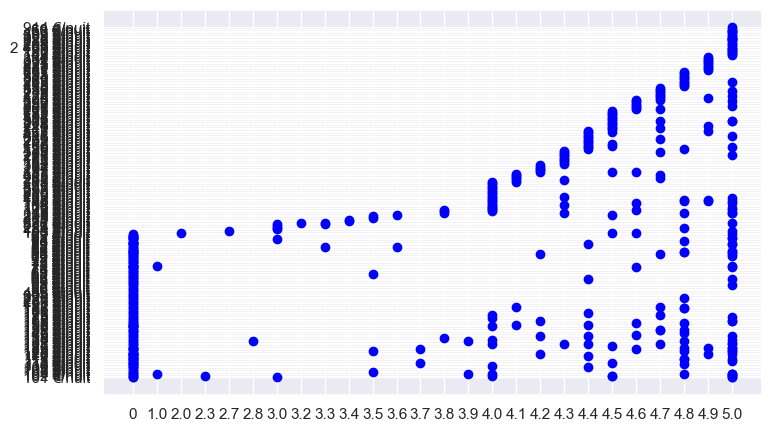

In [100]:
sorted_df = df.copy()
sorted_df = df.sort_values('Rating', ascending=True)
sorted_df = sorted_df[sorted_df['Rating'] != 0]


x = sorted_df["Rating"]
y = df["Price per Night"]


x_sorted, y_sorted = zip(*sorted(zip(x, y)))
# Create the scatter plot
plt.scatter(x_sorted, y_sorted, color='blue')


import numpy as np

# Fit a linear regression model to the data
model = np.polyfit(x_sorted, y_sorted, 1)
predict = np.poly1d(model)

# Create a range of x values to use for plotting the regression line
x_range = np.linspace(min(x_sorted), max(x_sorted), 100)

# Plot the scatter plot and the regression line
plt.scatter(x_sorted, y_sorted)
plt.plot(x_range, predict(x_range), color='r', linestyle='--', label='Tendancy')

plt.title('Does the rating have an impact on the price?')
plt.xlabel('Ratings')
plt.ylabel('Prices')
plt.legend()

In [120]:

df['Rating Category'] = pd.cut(df['Rating'], bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5], 
                               labels=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], 
                               include_lowest=True, right=False)
df

,Type,hote premium,Price per Night,Total Price,Rating,Appreciations,Type of annoucement,Number of Guests,Number of Bedrooms,Number of Beds,Rating Category
Name,,,,,,,,,,,
"95 m2 Appartement 5étage , 3 chambres, Wi-fi, Garage, Terrasse",Appartement,1,122.0,1592.0,4.5,51.0,Particulier,7.0,3.0,7.0,4.5
"Grand jardin, moyenne montagne, à la campagne,situation idyll. animaux acceptés",Appartement,0,63.0,818.0,4.7,58.0,Particulier,4.0,1.0,3.0,4.5
Bertogne: Ardennes Belges - Gite récent en bordure de forêt,Cottage,0,74.0,957.0,4.4,81.0,Particulier,6.0,3.0,7.0,4.0
Chalet Zutendaal,Chalet,0,65.0,851.0,0.0,0.0,rien,4.0,2.0,0.0,0.0
Ferme de Filot,Ferme,1,67.0,870.0,4.6,17.0,Particulier,4.0,1.0,2.0,4.5
"Bel appartement pour 4 personnes avec WIFI, TV et balcon",Appartement,0,122.0,1585.0,0.0,0.0,rien,4.0,2.0,0.0,0.0
Confortable gîte près du lac Robertville,Cottage,1,72.0,938.0,0.0,0.0,rien,4.0,2.0,4.0,0.0
"Face au Parlement Européen, bel appartement",Appartement,1,97.0,1255.0,4.8,66.0,Particulier,5.0,1.0,2.0,4.5
COCOONING en bord de Meuse.,Cottage,1,108.0,1408.0,4.8,13.0,Particulier,3.0,1.0,1.0,4.5


C:\Users\32498\anaconda3\envs\datamanagement\lib\site-packages\numpy\linalg\linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\32498\anaconda3\envs\datamanagement\lib\site-packages\matplotlib\axes\_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


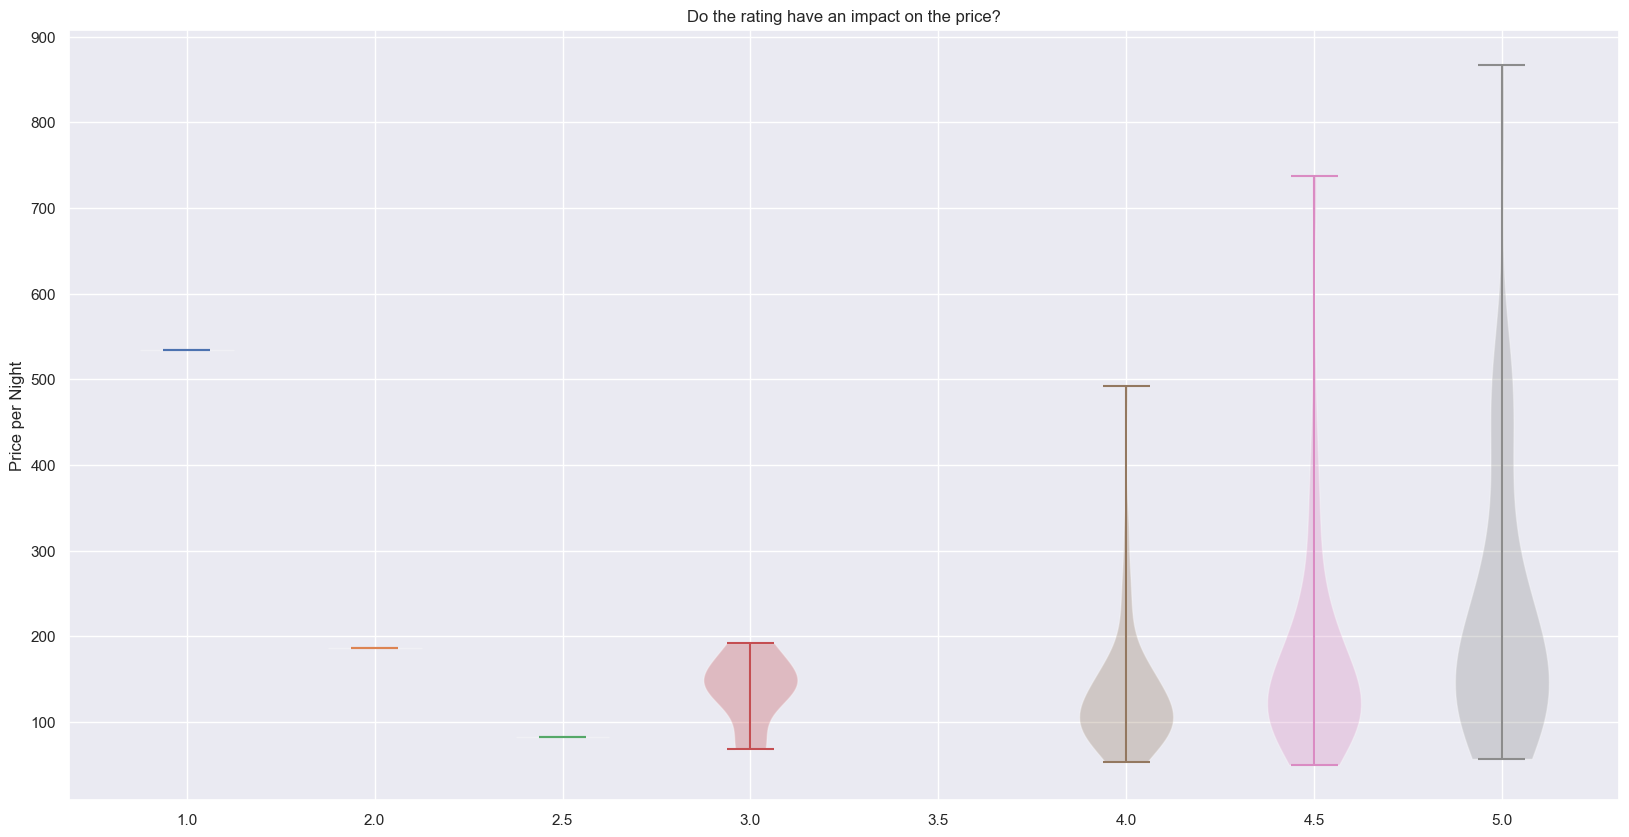

In [121]:
df_clean=df.copy()
df_clean = df_clean[df_clean['Rating Category'] != 0]

fig, ax = plt.subplots(figsize=(20, 10))
# sort the unique values of the Rating column in ascending order
ratings = sorted(df_clean["Rating Category"].unique())

for i, grp in enumerate(ratings):
    vplot = ax.violinplot(
        df_clean[df_clean["Rating Category"]==grp]["Price per Night"], positions=[i], vert=True
    )

ax.set_xticks(np.arange(len(ratings)))
ax.set_xticklabels(ratings)
ax.set_ylabel("Price per Night")
ax.set_title("Do the rating have an impact on the price?")
plt.show()

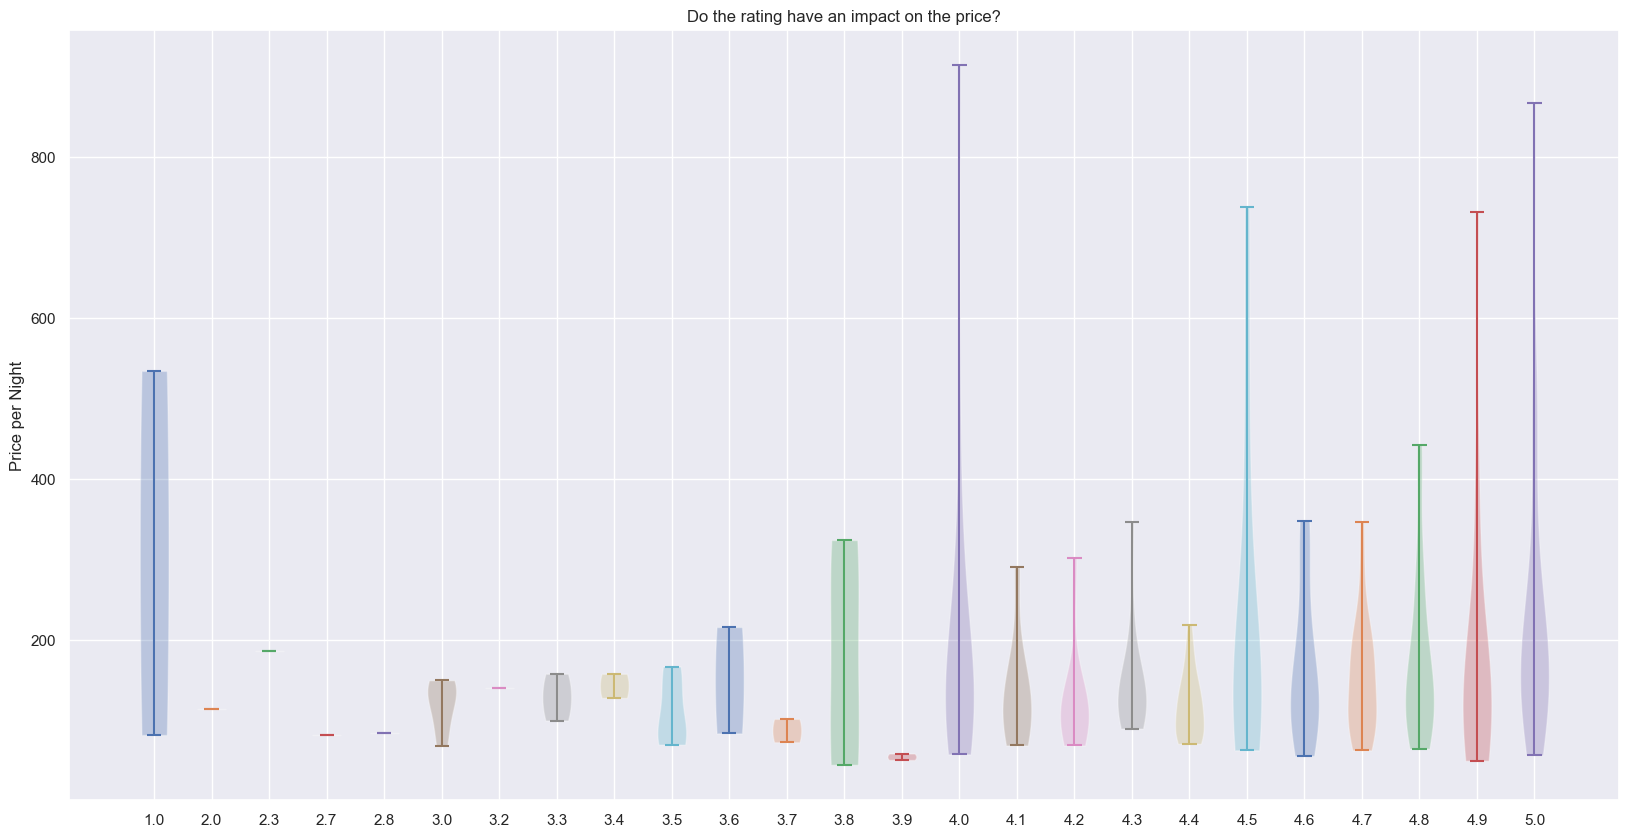

In [101]:
df['Price per Night'] = df['Price per Night'].astype(str).str.extract('(\d+)').astype(int)

df['Price per Night'] = pd.to_numeric(df['Price per Night'])
df['Price per Night'] = df['Price per Night'].astype(str).str.extract('(\d+)').astype(int)
df["Rating"] = pd.to_numeric(df["Rating"])



df_clean = df.copy()
df_clean = df_clean[df_clean['Rating'] != 0]


fig, ax = plt.subplots(figsize=(20, 10))
# sort the unique values of the Rating column in ascending order
ratings = sorted(df_clean["Rating"].unique())

for i, grp in enumerate(ratings):
    vplot = ax.violinplot(
        df_clean[df_clean["Rating"]==grp]["Price per Night"], positions=[i], vert=True
    )

ax.set_xticks(np.arange(len(ratings)))
ax.set_xticklabels(ratings)
ax.set_ylabel("Price per Night")
ax.set_title("Do the rating have an impact on the price?")
plt.show()


In [ ]:
#la base du violin

#df["Rating"] = pd.to_numeric(df["Rating"])
#fig, ax = plt.subplots()
#for i, grp in enumerate(df["Rating"].unique()):
#    vplot = ax.violinplot(
#        df["Rating"], positions=[i], vert=True
#    )
#labels = list(df["Rating"].unique())
#ax.set_xticks(np.arange(len(labels)))
#ax.set_xticklabels(labels)
#plt.show()

In [102]:
#df['Price per Night'] = df['Price per Night'].str.extract('(\d+)').astype(int)
df['Price per Night'] = pd.to_numeric(df['Price per Night'])


# Group the data by rating and compute the mean of the prices for each rating
mean_prices = df.groupby('Rating')['Price per Night'].mean()


# Group the data by rating and compute the mean of the prices for each rating
mean_prices = df.groupby('Rating')['Price per Night'].mean()

# Create a new DataFrame with the mean prices
mean_prices_df = pd.DataFrame({'Rating': mean_prices.index, 'Mean Price': mean_prices.values})

# Print the new DataFrame
print(mean_prices_df)

    Rating  Mean Price
0      0.0  176.906250
1      1.0  308.000000
2      2.0  114.000000
3      2.3  186.000000
4      2.7   82.000000
5      2.8   85.000000
6      3.0  120.000000
7      3.2  140.000000
8      3.3  129.000000
9      3.4  143.000000
10     3.5  110.600000
11     3.6  150.000000
12     3.7   87.500000
13     3.8  179.750000
14     3.9   55.000000
15     4.0  189.535714
16     4.1  136.625000
17     4.2  126.777778
18     4.3  147.714286
19     4.4  118.900000
20     4.5  235.181818
21     4.6  170.200000
22     4.7  154.285714
23     4.8  178.838710
24     4.9  184.875000
25     5.0  223.306667


In [103]:
for rating in df['Rating'].unique():
    mean_price = df.loc[df['Rating'] == rating, 'Price per Night'].mean()
    print(f"The mean value when a rental has a rating of {rating} is {mean_price:.2f}")


The mean value when a rental has a rating of 4.5 is 235.18
The mean value when a rental has a rating of 4.8 is 178.84
The mean value when a rental has a rating of 4.6 is 170.20
The mean value when a rental has a rating of 4.7 is 154.29
The mean value when a rental has a rating of 4.4 is 118.90
The mean value when a rental has a rating of 0.0 is 176.91
The mean value when a rental has a rating of 4.9 is 184.88
The mean value when a rental has a rating of 3.9 is 55.00
The mean value when a rental has a rating of 3.8 is 179.75
The mean value when a rental has a rating of 5.0 is 223.31
The mean value when a rental has a rating of 4.0 is 189.54
The mean value when a rental has a rating of 3.5 is 110.60
The mean value when a rental has a rating of 4.1 is 136.62
The mean value when a rental has a rating of 4.2 is 126.78
The mean value when a rental has a rating of 4.3 is 147.71
The mean value when a rental has a rating of 3.4 is 143.00
The mean value when a rental has a rating of 3.6 is 150.0

In [104]:
# Define the value of X
X = 3.5

# Convert 'Price per Night' column to numeric
df['Price per Night'] = pd.to_numeric(df['Price per Night'])

# Group the data by rating and compute the mean of the prices for each rating
mean_prices = df.groupby('Rating')['Price per Night'].mean()

# Loop over the ratings and print the mean price when the rating is X
for rating, mean_price in mean_prices.items():
    if rating == X:
        print(f"The mean price when the rating is {X} is {mean_price:.2f}")

The mean price when the rating is 3.5 is 110.60


ValueError: x and y must be the same size

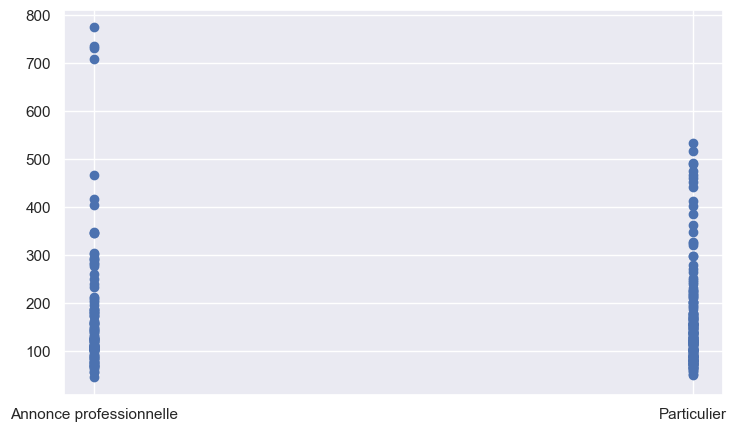

In [105]:
df_clean2 = df_clean[df_clean['Type of annoucement'] != 'rien']



y = df['Price per Night']
x= df_clean2['Type of annoucement']

x_sorted, y_sorted = zip(*sorted(zip(x, y)))

# Create the scatter plot
plt.scatter(x_sorted, y_sorted)

plt.scatter(x,y)
plt.title('Prices depending on ')
plt.xlabel('')
plt.ylabel('Prices')
plt.show()

In [106]:
# Group the data by rating and compute the mean of the prices for each rating
mean_prices = df.groupby('Type of annoucement')['Price per Night'].mean()

# Print the mean prices for each rating
print(mean_prices)

Type of annoucement
Annonce professionnelle    162.372263
Particulier                186.279621
rien                       191.263889
Name: Price per Night, dtype: float64


ValueError: x and y must be the same size

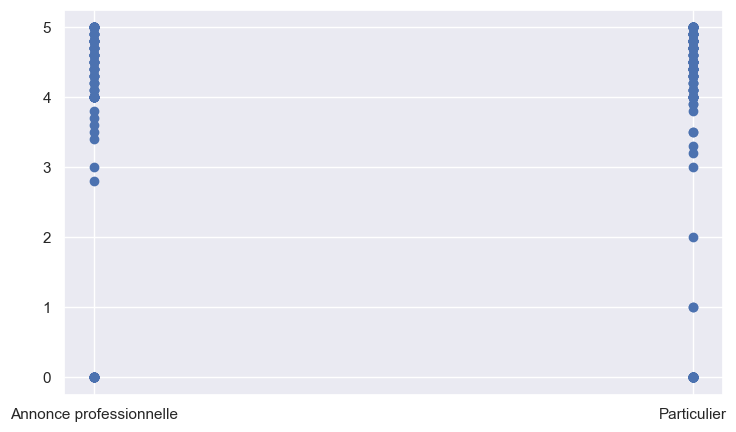

In [107]:
df_clean2 = df_clean[df_clean['Type of annoucement'] != 'rien']

y = df['Rating']
x= df_clean2['Type of annoucement']

x_sorted, y_sorted = zip(*sorted(zip(x, y)))

# Create the scatter plot
plt.scatter(x_sorted, y_sorted)

plt.scatter(x,y)
plt.title('Ratings depending on housing type')
plt.xlabel('Housing type')
plt.ylabel('Ratings')
plt.show()

In [108]:
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

mean_ratings = df.groupby('Type of annoucement')['Rating'].mean()

# afficher les moyennes des ratings pour chaque rating status
print(mean_ratings)

Type of annoucement
Annonce professionnelle    3.481752
Particulier                3.673934
rien                       0.726389
Name: Rating, dtype: float64


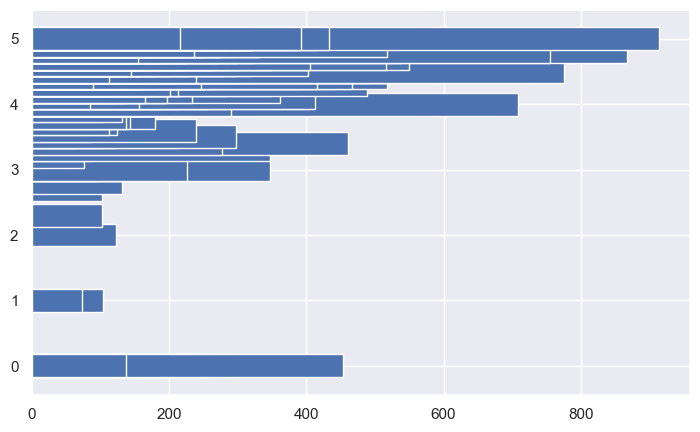

In [109]:
x = df["Rating"]


x_sorted, y_sorted = zip(*sorted(zip(x, y)))

fig, ax = plt.subplots()
ax.barh(x_sorted, df["Price per Night"], 0.35)
ax.set_xlabel("")
plt.show()

## Maps

In [66]:
import folium

# Centrer la carte sur Bruxelles
map = folium.Map(location=[50.8466, 4.3517], zoom_start=8)

for Name, row in dfloc_total.iterrows():
    if not pd.isna(row['latitude']) and not pd.isna(row['longitude']):
        marker=folium.Marker(location=[row['latitude'], row['longitude']]).add_to(map)
        marker.add_child(folium.Popup(Name))

# Afficher la carte
map

In [28]:
pip install HeatMap

  Using cached heatmap-2.2.1.zip (25 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [7 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\32498\AppData\Local\Temp\pip-install-zz6ozagt\heatmap_10149285d0bf4ef7b32f9d8cb3965718\setup.py", line 15
      print "On Windows, skipping build_ext."
            ^
  SyntaxError: Missing parentheses in call to 'print'. Did you mean print("On Windows, skipping build_ext.")?
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [67]:
from folium import plugins

m = folium.Map(location=[50.8466, 4.3517], zoom_start=7.5)

# Create a heatmap layer based on the price of each location
heatmap_data = []
for index, row in merged_df.iterrows():
    if not pd.isna(row['latitude']) and not pd.isna(row['longitude']):
        heatmap_data.append([row['latitude'], row['longitude'], row['Price per Night']])

# Add the heatmap layer to the map
plugins.HeatMap(heatmap_data, name='Price heatmap').add_to(m)
m

In [68]:
from folium import plugins

m2 = folium.Map(location=[50.8466, 4.3517], zoom_start=7.5)

# Create a heatmap layer based on the price of each location
heatmap_data_2 = []
for index, row in merged_df.iterrows():
    if not pd.isna(row['latitude']) and not pd.isna(row['longitude']):
        heatmap_data.append([row['latitude'], row['longitude'], row['Rating']])

# Add the heatmap layer to the map
plugins.HeatMap(heatmap_data, name='Rating heatmap').add_to(m2)
m2

In [69]:
from folium.plugins import HeatMapWithTime

m3 = folium.Map(location=[50.8466, 4.3517], zoom_start=7.5)

# Create a list of data points for the heatmap

data = []
labels = []
for index, row in merged_df.iterrows():
    if not pd.isna(row['latitude']) and not pd.isna(row['longitude']):
        data.append([row['latitude'], row['longitude'], row['Price per Night'], row['Rating']])
        labels.append(f"Price: {row['Price per Night']}, Rating: {row['Rating']}")
# Create a HeatMapWithTime object and add it to the map
hm = HeatMapWithTime(data, index=labels, auto_play=True, max_opacity=0.8,radius=30,gradient={0.2: 'blue', 0.4: 'green', 0.6: 'yellow', 1: 'red'}, name="Price vs. Rating heatmap")
hm.add_to(m3)
m3

## Correlation

In [77]:
merged_df['hote premium']=merged_df['hote premium'].astype('float')

In [78]:
df_numerical = merged_df.select_dtypes(include='float')
features= df_numerical.drop(columns=['Total Price','latitude','longitude'])#input
features

,hote premium,Price per Night,Rating,Appreciations,Number of Guests,Number of Bedrooms,Number of Beds
Name,,,,,,,
"95 m2 Appartement 5étage , 3 chambres, Wi-fi, Garage, Terrasse",1.0,122.0,4.5,51.0,7.0,3.0,7.0
"Grand jardin, moyenne montagne, à la campagne,situation idyll. animaux acceptés",0.0,63.0,4.7,58.0,4.0,1.0,3.0
Bertogne: Ardennes Belges - Gite récent en bordure de forêt,0.0,74.0,4.4,81.0,6.0,3.0,7.0
Chalet Zutendaal,0.0,65.0,0.0,0.0,4.0,2.0,0.0
Chalet Zutendaal,0.0,65.0,0.0,0.0,4.0,2.0,0.0
Chalet Zutendaal,0.0,86.0,0.0,0.0,6.0,3.0,0.0
Chalet Zutendaal,0.0,86.0,0.0,0.0,6.0,3.0,0.0
Ferme de Filot,1.0,67.0,4.6,17.0,4.0,1.0,2.0
Confortable gîte près du lac Robertville,1.0,72.0,0.0,0.0,4.0,2.0,4.0


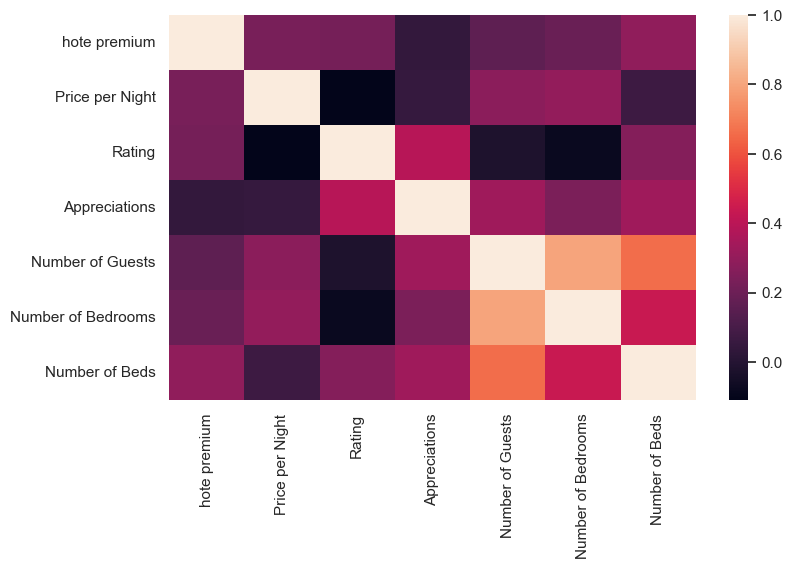

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

#input
sns.set(rc={'figure.figsize':(8.5,5)})
correlation_matrix = features.corr().round(2)#pq round (2)?
sns.heatmap(correlation_matrix) #annot=True
#heatmat c'est une fonction de seaborn
plt.show()

#faudrait surement bouger longitude et lattitude?
#faudrait peut etre ajouter hote premium mais c'est une variable dummies donc jsp

# 3. Machine Learning